<a href="https://colab.research.google.com/github/jhyoo78/jhyoo78/blob/main/Next_Sentence_prediction_FastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 참고 --> https://www.kaggle.com/code/ysthehurricane/next-word-prediction-bi-lstm-tutorial-easy-way

import os
import numpy as np

# 하나의 문장 내에서 다음 단어들을 맞출 때 import할 것들
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 단어가 아닌 sentence 단위로 전처리할 경우
import nltk
nltk.download('punkt')   # ‘punkt=문장 tokenizer’를 다운로드
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import  stopwords
import re                # 파이썬 정규표현을 위한 표준 라이브러리임

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import files     # Colab에서 local PC내의 file 읽어 들이는 라이브러리
uploaded = files.upload()          # 전처리한 정상상태 log ==train.txt, senticnet.xlsx 와 test.txt (vnf3_0601_log.txt를 전처리 한 것) 파일을 선택하여 저장

Saving train.txt to train.txt


# FastText embedding을 위한 전처리

In [ ]:
pre_processed_text = []

f = open('train.txt', 'r', encoding='UTF8')          # 1,100 줄의 log 파일
lines = f.readlines()

for line in lines:
    sent_text = sent_tokenize(line)     #  log msg를 줄 단위의 sentence로 토큰화
    #print(sent_text)

    # 각 문장에 대해서 구두점, LF 등을 제거하고, 대문자를 소문자로 변환.
    for string in sent_text:
        tokens = re.sub(r"[^a-z]+", " ", string.lower())   # 숫자 제거
        pre_processed_text.append(tokens)

f.close()

print("pre_processed_text=", pre_processed_text)
result=[pre_processed_text]
# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
#result = [word_tokenize(sentence) for sentence in pre_processed_text]

print('총 샘플의 개수 : {}'.format(len(result)))
print(result)
print(len(result[0]))

pre_processed_text= ['rsyslogd origin softwarersyslogd swversion xpid xinfohttpswwwrsyslogcom rsyslogd huped', 'systemd starting rotate log files', 'systemd starting daily mandb regeneration', 'systemd logrotateservice succeeded', 'systemd finished rotate log files', 'systemd mandbservice succeeded', 'systemd finished daily mandb regeneration', 'packagekit daemon start', 'dbus daemon system activating via systemd service nameorgfreedesktoppackagekit unitpackagekitservice requested uid pid commusrbingdbus call system dest orgfreedeskto labelunconfined', 'dbus daemon system successfully activated service orgfreedesktoppackagekit', 'systemd starting daily apt download activities', 'systemd starting packagekit daemon', 'systemd started packagekit daemon', 'systemd aptdailyservice succeeded', 'systemd finished daily apt download activities', 'packagekit daemon quit', 'systemd packagekitservice succeeded', 'server systemd resolved server returned error nxdomain mitigating potential dns viola

# FastText로 훈련하고 결과 저장

In [ ]:
# FastText로 훈련하고 결과 저장하기

from gensim.models import FastText
model = FastText(result, size=200, window=5, min_count=1, workers=4, sg=1)

model.save('fasttext_log')       # Keras는 모델의 구조와 가중치를 저장할 때 h5 파일형식을 권고
#model.wv.save_word2vec_format('fasttext_embedding') # Word2Vec 명령임. fasttext에는 오류 발생

In [ ]:
# FastText 훈련 결과 확인
model.wv.most_similar('systemd started message of the day', topn=5)

[('server systemd starting daily apt download activities', 0.9525443315505981),
 ('server systemd starting daily apt upgrade clean activities',
  0.9511708617210388),
 ('server systemd started daily apt download activities', 0.9482792615890503),
 ('server systemd started daily apt upgrade clean activities',
  0.9477164149284363),
 ('server systemd starting message day', 0.9396107196807861)]

# 전처리 한 정상 상태 log를 토큰화함

In [ ]:
# log msg 를 sentence 단위로 토큰화 처리
input_sequences = []
log_sent = []

f = open('train.txt', 'r')          # 1,100 줄의 log 파일
lines = f.readlines()

for line in lines:
    sent_tok =  nltk.sent_tokenize(line)     #  log msg를 줄 단위로 sentence로 토큰화
    log_sent.append(sent_tok)

f.close()

print("log_sents=", log_sent)
print("num_sent=", len(log_sent))

tokenizer = Tokenizer(oov_token='<oov>')     #  토큰화할 때 적용할 파라미터 --> 없는 단어를 '<oov>'로 처리함.
tokenizer.fit_on_texts(log_sent)             #  전체 문장의 index와 단어 벡터를 생성(Keras)
total_words = len(tokenizer.word_index) + 1  #  계산된 단어(문장)의 index를 dictionary 형태(word_index)로 변환

print("total unique sentences=", total_words)
print("tokeniizer.word_index=", tokenizer.word_index)

for msg in log_sent:
    #print(msg)                                    # log msg를 한 줄씩 출력
    token_list = tokenizer.texts_to_sequences([msg])[0]  # 각 문장(line)에 index를 부여해줌.
    #print("token_list=",token_list)                              # --> [
    input_sequences.append(token_list)
print("input_sequence=", input_sequences)       # ---> [[92], [93], [94], [95], [96], [97], [40],....] 등으로 출력됨
print("Total input sequences: ", len(input_sequences))    # ---> log file의 line 수
f.close()

log_sents= [['rsyslogd origin softwarersyslogd swversion xpid xinfohttpswwwrsyslogcom rsyslogd huped'], ['systemd starting rotate log files'], ['systemd starting daily mandb regeneration'], ['systemd logrotateservice succeeded'], ['systemd finished rotate log files'], ['systemd mandbservice succeeded'], ['systemd finished daily mandb regeneration'], ['packagekit daemon start'], ['dbus-daemon system activating via systemd service nameorgfreedesktoppackagekit unitpackagekitservice requested uid pid commusrbingdbus call system dest orgfreedeskto labelunconfined'], ['dbus-daemon system successfully activated service orgfreedesktoppackagekit'], ['systemd starting daily apt download activities'], ['systemd starting packagekit daemon'], ['systemd started packagekit daemon'], ['systemd aptdailyservice succeeded'], ['systemd finished daily apt download activities'], ['packagekit daemon quit'], ['systemd packagekitservice succeeded'], ['server systemd-resolved server returned error nxdomain miti

# 학습에 사용할 log 데이터의 차원 변경

In [ ]:
# Padding 대신에 학습에 사용할 log 데이터의 차원 변경을 위해 마지막 몇개 log msg를 버리고, 2차원(n x dim)으로 재구성하기

dim=4

new_input = []

input_seq = np.concatenate(input_sequences).tolist()
print("input_seq=",len(input_seq), "개 -->", input_seq)

for i in range(len(input_sequences)-dim-1):
    new_input.append(input_seq[i: i+dim])
np_new_input = np.array(new_input)

print(np_new_input)
print(len(np_new_input))


input_seq= 12528 개 --> [966, 78, 114, 115, 79, 116, 117, 100, 169, 170, 29, 101, 111, 42, 31, 112, 171, 90, 43, 44, 95, 96, 24, 41, 25, 46, 47, 48, 49, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 59, 60, 86, 329, 330, 30, 37, 45, 102, 91, 118, 119, 120, 87, 121, 92, 122, 123, 63, 97, 29, 42, 31, 59, 60, 30, 37, 45, 102, 91, 95, 96, 24, 41, 25, 991, 43, 44, 63, 43, 44, 46, 47, 48, 49, 17, 18, 19, 20, 23, 26, 17, 18, 23, 17, 18, 19, 32, 26, 32, 19, 20, 28, 28, 20, 23, 26, 17, 18, 23, 19, 32, 26, 32, 20, 28, 28, 17, 18, 19, 20, 23, 26, 17, 18, 23, 19, 26, 20, 29, 42, 31, 56, 56, 56, 966, 78, 114, 115, 79, 116, 117, 95, 96, 24, 41, 25, 100, 169, 170, 29, 101, 111, 42, 31, 112, 171, 100, 169, 170, 87, 101, 111, 121, 92, 112, 171, 118, 119, 120, 122, 123, 17, 18, 23, 17, 18, 23, 19, 32, 26, 32, 19, 26, 20, 28, 28, 20, 17, 18, 19, 20, 17, 18, 23, 19, 32, 26, 32, 20, 28, 28, 17, 18, 23, 19, 26, 20, 188, 189

# Xs, Ys 생성

In [ ]:
# create features and label

xs, labels = np_new_input[:, :-1],np_new_input[:,-1]   #  [:, :] 는 [all rows, all columns]을 지칭,  [:, :-1]은 all rows 와 마지막 column을 제외한 all columns, [:, -1] 은 last column의 모든 rows를 지칭
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)  # labels 내의 index 값으로 (전체 문장 개수에 대한) One-hot encoding을 해줌.

print("xs, shape=", xs.shape)
print("labels=", labels)
print("ys=", ys)
print("labels_shape=",labels.shape)
print("ys_shape=", ys.shape)


xs, shape= (12523, 3)
labels= [115  79 116 ...  32  20  28]
ys= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
labels_shape= (12523,)
ys_shape= (12523, 1500)


In [ ]:
# FastText embedding model 불러오기

loaded_model = FastText.load("fasttext_log")
#model = FastText.load_fasttext_format('fasttext_log.h5')   # 재시도해 볼것...

In [ ]:
print('모델의 크기(shape) :',loaded_model) # FastText 모델의 크기 확인

vocab_size= len(tokenizer.word_index.items()) +1   # 아래 cell에서 확인할 것

def get_vector(str):
    if str in loaded_model:
        return loaded_model[str]
    else:
        return None;

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))

for word, index in tokenizer.word_index.items():
    # 단어와 매핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value


print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix))


모델의 크기(shape) : FastText(vocab=1481, size=200, alpha=0.025)


<ipython-input-24-d0d9d5459f2c>:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if str in loaded_model:
<ipython-input-24-d0d9d5459f2c>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return loaded_model[str]


임베딩 행렬의 크기(shape) : (1500, 200)


In [ ]:
print(tokenizer.word_index.items())  #각 sentence 와 매핑된 index 값을 확인해보자.

dict_items([('<oov>', 1), ('kernel acpiphp slot registered', 2), ('systemd starting snap daemon', 3), ('systemd stopped snap daemon', 4), ('systemd snapd service scheduled restart job restart counter', 5), ('snapd apparmor status apparmor enabled features available', 6), ('systemd snapd service start operation timed terminating', 7), ('systemd snapd service failed result timeout', 8), ('systemd failed start snap daemon', 9), ('server ovs-vswitchd ovssocketutilerreno valid ip address', 10), ('systemd-timesyncd timed waiting reply      ntp ubuntu com', 11), ('cloud-init ciinfo', 12), ('systemd-timesyncd network configuration changed trying establish connection', 13), ('kernel pm registered nosave memory mem', 14), ('kernel platform eisa allocate resource eisa slot', 15), ('kernel disabled', 16), ('sshd accepted password ubuntu port ssh', 17), ('sshd pamunixsshdsession session opened user ubuntu uid', 18), ('systemd-logind new session user ubuntu', 19), ('systemd started session user ubun

In [ ]:
print(loaded_model['nit ciinfo'])   # log 파일에 없는 깨진 msg에도 정상 동작함

[-0.0057686  -0.30308914  0.13034888 -0.15457262 -0.6676376   0.68465984
 -0.5169494  -1.1282718  -0.68851227  0.78397787 -0.20385112  0.08899429
 -0.49034563 -1.6413418   1.2419705   0.22945668  0.09253578  0.43067735
  0.2661293   0.33130878 -0.35787955  0.9576274   0.9980417   0.3138652
  0.35109738 -0.6404387   0.2920159  -0.48177296  1.4319656  -0.61645585
 -0.5555731  -0.07197135 -0.34007493 -0.28827396 -0.05891816  0.04926185
  0.44211376 -0.3895623  -0.63461095  0.4420237  -0.75899696  0.3937689
 -0.1490544  -0.47997257  0.33004755  0.92931384  0.5500446  -0.13977173
  0.7434396   0.02046848 -0.47972903 -0.48891333 -1.0438124  -0.47656208
  0.41668925  0.13400671 -1.0968688   0.11174587 -0.17484221 -1.0316613
  0.28144342  0.30918157  0.49151456 -0.44855824  1.2183014   1.2039396
 -0.08547359  0.14848737  0.06138245 -0.50978494 -0.18427038  0.19442792
  1.0383924  -0.16785826 -0.128636    0.8679697   0.40387473  0.54406166
 -0.64471376 -0.37830502  0.10520878  0.20488118  1.012

<ipython-input-14-06ab9fd3ceed>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(loaded_model['nit ciinfo'])   # log 파일에 없는 깨진 msg에도 정상 동작함


In [ ]:
# Bi- LSTM Neural Network Model training

model = Sequential()
#model.add(Embedding(total_words, 100, input_length = dim-1))
model.add(Embedding(total_words, 200, weights=[embedding_matrix], input_length = dim-1))   ########### FastText embedding으로 수정함.  202301230 00:08, trainable 사용 불가함.
model.add(Bidirectional(LSTM(64, return_sequences =True)))  # 추가

model.add(Bidirectional(LSTM(256)))                     # hidden units의 개수를 늘리기보다, 더 많은 hidden layer을 쌓는게 효과적, 수정 필요함.
#model.add(Dropout(0.1))                 # 과적합 방지 0.2
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=30, verbose=1)  # epoch=50,   xs와 ys에 대해 학습을 시작함. 20--> 30으로 증대
#print model.summary()
print(model)

Epoch 1/30
392/392 [==============================] - 15s 19ms/step - loss: 4.6739 - accuracy: 0.2150
Epoch 2/30
392/392 [==============================] - 5s 12ms/step - loss: 1.7945 - accuracy: 0.6411
Epoch 3/30
392/392 [==============================] - 5s 12ms/step - loss: 1.1370 - accuracy: 0.7533
Epoch 4/30
392/392 [==============================] - 4s 11ms/step - loss: 0.8784 - accuracy: 0.7958
Epoch 5/30
392/392 [==============================] - 4s 11ms/step - loss: 0.7532 - accuracy: 0.8124
Epoch 6/30
392/392 [==============================] - 4s 11ms/step - loss: 0.6411 - accuracy: 0.8375
Epoch 7/30
392/392 [==============================] - 5s 13ms/step - loss: 0.5716 - accuracy: 0.8500
Epoch 8/30
392/392 [==============================] - 5s 13ms/step - loss: 0.5204 - accuracy: 0.8592
Epoch 9/30
392/392 [==============================] - 4s 9ms/step - loss: 0.4810 - accuracy: 0.8654
Epoch 10/30
392/392 [==============================] - 4s 10ms/step - loss: 0.4567 - accura

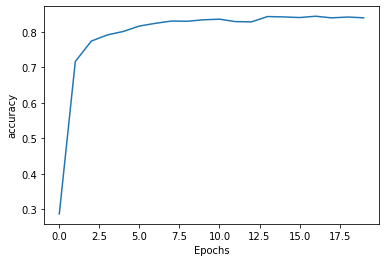

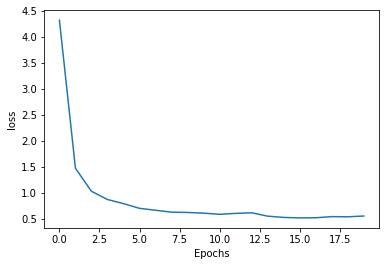

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Model 시험하기

연속된 2개의 문장으로 한 개의 다음 문장 예측하기

In [ ]:
# 연속된 N개의 문장으로 한 개의 다음 문장 예측하기

#seed_text = 'init ciinfo', 'init ciinfo route ipv info'
seed_text = 'systemd-logind new session user ubuntu', 'systemd-logind session logged waiting processes exit', 'systemd started session user ubuntu'

''' --------------------  실제 log msg를 파일에서 읽어 처리할 때  ------------------------'''
# model.pridict에 입력할 token_list 만들기
seed_tok=[]
for i in range(dim-1):
    sd =  nltk.sent_tokenize(seed_text[i])   #  한 줄의 log msg를 sentence 단위로 토큰화
    seed_tok.append(sd)
print("seed_tok=", seed_tok)

token = tokenizer.texts_to_sequences(seed_tok)
print("token_list=", token)                 # 입력 문장의 index 값

token_list=[]
for a in token:
    token_list.append(a[0])
token_list=[token_list]
print("token_list=", token_list)             # token_list = [[1, 2]] 와 같은 2차원 배열로 표시되어야 함
'''-------------------------------------------------------------------------------------------'''

y_prob = model.predict(token_list, verbose=0)    # model.predicted()는 token_list(X-train)의 개수만큼 예측 결과를 출력함
print(y_prob[0][:20], len(y_prob[0]))            # total_words(913개 unique 문장) 각각에 대한 확률 --> [[1.3384e-06 1.2275e-06 5.1810e-04 ... 3.392e-05]]


predicted = y_prob[0].argmax(axis=-1)            # 가장 큰 확률 값을 갖는 단어의 index를 선택
                                                 # axis가 0 이면 2차원 행렬에서 열(가장 높은 차원), axis=1이면 행(다음으로 높은 차원), axis=-1이면 마지막 차원(가장 낮은 차원, 2차원에서는 행)을 기준 축으로 함
                                                 # argmax()는 가장 큰 값이 아닌 그 값의 인덱스 값을 반환함.
print("predicted=", predicted)
prob= np.max(y_prob, axis=1)

#pred_rank = sorted(y_prob[0], reverse = True)                  #  값이 큰 것부터 정렬(reverse=True), sort()는 원본 자료를 수정하고, sorted()는 원본은 그대로 두고 수정한 것을 리턴함.
#print(pred_rank[0][:5])
#print(pred_rank)

output_word = ""
for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
    if index == predicted:
        output_word = word
        break
seed_text = output_word
print(seed_text, prob)

seed_tok= [['systemd-logind new session user ubuntu'], ['systemd-logind session logged waiting processes exit'], ['systemd started session user ubuntu']]
token_list= [[19], [26], [20]]
token_list= [[19, 26, 20]]
[2.0053083e-08 1.8931997e-08 2.9749339e-07 3.9082619e-07 4.1614425e-07
 4.3058769e-08 1.3171399e-05 3.7452619e-10 2.4822616e-06 3.8760322e-07
 3.6994340e-06 4.9121300e-05 9.6613439e-07 9.6477527e-07 3.3314770e-08
 2.8780255e-07 1.3760730e-08 5.1628295e-03 2.0565135e-06 5.4399093e-04] 1500
predicted= 28
systemd sessionscope succeeded [0.9537201]


연속된 3개의 문장으로 다수의 Next Sentence를 예측하기

In [ ]:
seed_text = 'systemd-logind new session user ubuntu', 'systemd-logind session logged waiting processes exit', 'systemd started session user ubuntu'


num_to_predict = 3   # 예측할  다음 문장의 개수
''' --------------------  실제 log msg를 파일에서 읽어 처리할 때  ------------------------'''
# model.pridict에 입력할 token_list 만들기
seed_tok=[]
for i in range(dim-1):
    sd =  nltk.sent_tokenize(seed_text[i])   #  한 줄의 log msg를 sentence 단위로 토큰화
    seed_tok.append(sd)
print("seed_tok=", seed_tok)

token = tokenizer.texts_to_sequences(seed_tok)
print("token_list=", token)                 # 입력 문장의 index 값

token_list=[]
for a in token:
    token_list.append(a[0])
token_list=[token_list]
print("token_list=", token_list)            # token_list = [[1, 2]] 와 같은 2차원 배열로 표시되어야 함
'''-------------------------------------------------------------------------------------------'''
print("")

y_prob = model.predict(token_list, verbose=0)    # model.predicted_classes 는 deprecated
#print(y_prob)

for i in range(num_to_predict):
    predicted = y_prob[0].argmax(axis=-1)
    print("predicted index =", predicted)

    prob= np.max(y_prob, axis=1)         # 2차원 array인 경우에 axis 사용함, 하나의 row에서 최대인 값
    np.put(y_prob[0], predicted, 0)         # np.array는 요소를 delete를 하면 새 array를 return하고 원본에서는 삭제가 안된다. 단, np.put(array, index, value) 등으로 변경은 가능하다.
    #np.delete(y_prob, predicted)

    output_word = ""
    for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
        if index == predicted:
            output_word = word
            break
    print("[", i+1,"번 ]", output_word, prob)


seed_tok= [['systemd-logind new session user ubuntu'], ['systemd-logind session logged waiting processes exit'], ['systemd started session user ubuntu']]
token_list= [[19], [26], [20]]
token_list= [[19, 26, 20]]

predicted index = 28
[ 1 번 ] systemd sessionscope succeeded [0.9537201]
predicted index = 188
[ 2 번 ] sshd received disconnect port disconnected user [0.00937713]
predicted index = 78
[ 3 번 ] systemd starting rotate log files [0.00566975]


#EOF
   2023/02/01 20:48